In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score


import json, os

In [3]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
cuda = 'cuda'
cpu = 'cpu' 
device = cuda if torch.cuda.is_available() else cpu


In [4]:
with open("mapping.json", 'r') as f:
    mapping = json.load(f)
    

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate= (.15, .15), scale = (0.85, 1.15)),

    transforms.Resize((299,299)), #Resize data to be 224x224.
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((324, 324)),
    transforms.TenCrop((299, 299)),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    ])

In [5]:

class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   


In [6]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)

train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)

batch_size=64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, 
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False   
)   

label: fighter-jet (index - 69)


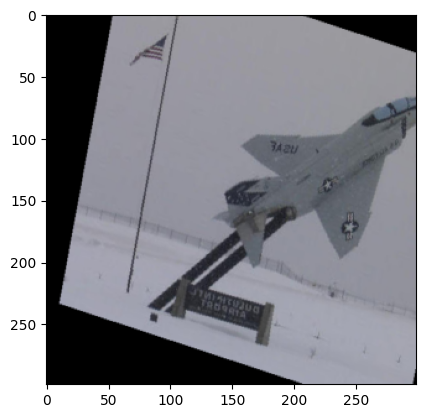

In [7]:
#visualize an image from train_dataset

i = 1135

image = train_dataset[i][0].permute(1, 2, 0).numpy()
label = mapping[str(train_dataset[i][1]+1)] #+1 is required, because the "class 1" in folders, is class 0 when torch loads it

print(f"label: {label} (index - {train_dataset[i][1]+1})")
plt.imshow(image)

In [ ]:
class BNConv2D(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride = 1,
            padding= 0,
            dilation=1,
            groups=1,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)


    def forward(self, X):
        
        out = self.conv(X)
        out = self.bn(out)

        return out
    
class BN_DepthwiseSeparableConv2D(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride = 1,
            padding= 0,
            dilation=1,
    ):
        super().__init__()

        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=False
        )
        self.pointwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, X):

        out = self.depthwise_conv(X)
        out = self.pointwise_conv(out)
        out = self.bn(out)

        return out

class Xception(nn.Module):
    """
    [paper](https://arxiv.org/pdf/1610.02357) from where this is implemented
    """

    def __init__(self, ):
        super().__init__()


        ## ENTRY FLOW
        self.block1_conv1 = BN_DepthwiseSeparableConv2D(in_channels=3, out_channels=32, stride=2, kernel_size=3)
        self.block1_conv2 = BN_DepthwiseSeparableConv2D(in_channels=32, out_channels=64, kernel_size=3)
        

        self.residual1 = BNConv2D(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=2)
        self.residual2 = BNConv2D(in_channels=128, out_channels=256, kernel_size=1, padding=0, stride=2)
        # self.residual3 = BNConv2D(in_channels=256, out_channels=728, kernel_size=1, padding=0, stride=2)


        self.block2_conv1 = BN_DepthwiseSeparableConv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.block2_conv2 = BN_DepthwiseSeparableConv2D(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.block3_conv1 = BN_DepthwiseSeparableConv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.block3_conv2 = BN_DepthwiseSeparableConv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # self.block4_conv1 = BN_DepthwiseSeparableConv2D(in_channels=256, out_channels=728, kernel_size=3, padding=1)
        # self.block4_conv2 = BN_DepthwiseSeparableConv2D(in_channels=728, out_channels=728, kernel_size=3, padding=1)


        ## MIDDLE FLOW

        


        

        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, X):

        #block 1
        out = self.block1_conv1(X)
        out = self.relu(out)
        out = self.block1_conv2(out)
        out = self.relu(out)
        
        #block 2
        residual = self.residual1(out)

        out = self.block2_conv1(out)
        out = self.relu(out)
        out = self.block2_conv2(out)
        out = self.max_pooling(out)

        out += residual
        
        #block 3
        residual = self.residual2(out)

        out = self.relu(out)
        out = self.block3_conv1(out)
        out = self.relu(out)
        out = self.block3_conv2(out)
        out = self.max_pooling(out)

        out += residual

        #block 4
        # residual = self.residual3(out)

        # out = self.relu(out)
        # out = self.block4_conv1(out)
        # out = self.relu(out)
        # out = self.block4_conv2(out)
        # out = self.max_pooling(out)

        # out += residual

        return out

        

In [31]:
model = Xception()


In [26]:
x, y = next(iter(train_loader))

In [32]:
out = model(x)

In [34]:
out.shape

torch.Size([64, 256, 37, 37])

In [38]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


x = nn.BatchNorm2d(10) 

count_trainable_parameters(x)


20